# Gaussian processes, neural processes and Bayesian neural networks

This notebook demonstrates several Bayesian models applied to time series data from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). First, we import the necessary libraries and enable 64-bit support for `JAX`.

In [1]:
import numpy as np
import optax

%matplotlib inline
import matplotlib.pyplot as plt
import palettes

from flax import linen as nn
from jax import numpy as jnp
from jax import random as jr
from jax.config import config

from ramsey.data import m4_data
from ramsey.experimental import Autoregressive

# for GPs, we kinda need 64 bit precision
config.update("jax_enable_x64", True)
palettes.set_theme()

We load the hourly M4 competition time series data. After removing all time series that contain NaNs, we get 245 time series with 1008 observations (time points) each.

In [2]:
data = m4_data(drop_na=True)
y = data.y
y.shape

(245, 1008, 1)

Of these time series we select four (that have sufficient variety) and to make training times shorter we only select 200 observations of each time series which we (arbitrarily) split into 180 training samples and 20 test samples. We also standardize them, because as of now, our GP models don't support mean functions.

In [3]:
n_series = 4
idxs_series = jnp.array([28, 32, 242, 12])

n = 200
n_train = 180

x = jnp.arange(n) / n_train
x = jnp.tile(x, [n_series, 1]).reshape((n_series, n, 1))
y = y[idxs_series, :n, :]
y = (y - y.mean(axis=1, keepdims=True)) / y.std(axis=1, keepdims=True)

x_train, x_test = x[:, :n_train, :], x[:, n_train:, :]
y_train, y_test = y[:, :n_train, :], y[:, n_train:, :]

Let's have a look at the time series:

/Users/simon/miniconda3/envs/ramsey-dev/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


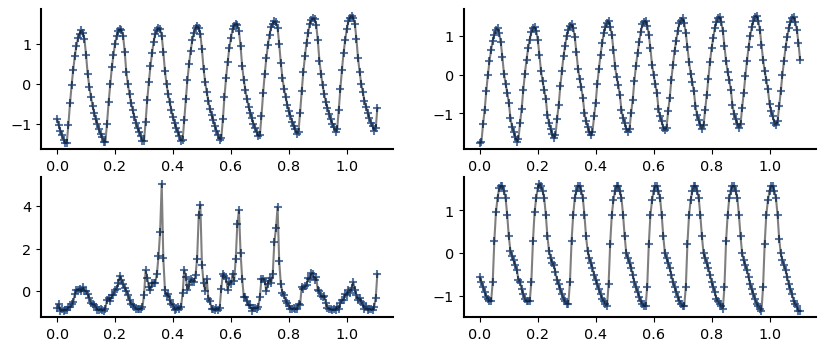

In [4]:
cols = palettes.discrete_sequential_colors(1)
_, axes = plt.subplots(figsize=(10, 4), nrows=2, ncols=2)

for _, (idx, ax) in enumerate(zip([0, 1, 2, 3], axes.flatten())):
    xs = np.squeeze(x[idx, :, :])
    ys = np.squeeze(y[idx, :, :])
    idxs = np.argsort(xs)
    ax.plot(xs[idxs], ys[idxs], color="black", alpha=0.5)
    ax.scatter(xs[idxs], ys[idxs], color="#204a87", marker="+", alpha=0.75)
plt.show()

# Gaussian Process (GP)

To fit a Gaussian process, we import the GP class, some covariance functions, and a function for training.

In [ ]:
from ramsey.experimental import GP, ExponentiatedQuadratic, Periodic
from ramsey.experimental import train_gaussian_process

Next we define the kernel. As shown below a combination of different basic kernel functions is used.

In [ ]:
def get_gaussian_process():
    kernel = ExponentiatedQuadratic() + Periodic(x[0, 1, 0] * 24)
    gp = GP(kernel)
    return gp

Next we define functions for training the GP and plotting the results.

In [ ]:
def train(rng_key, y, x):
    gaussian_process = get_gaussian_process()
    params, _ = train_gaussian_process(
        rng_key, gaussian_process, x=x, y=y
    )

    return gaussian_process, params

In [ ]:
def plot(ax, seed, gaussian_process, params, y_train, x_train, y_test, x_test):
    x_star = jnp.concatenate((x_train, x_test))
    apply_key, seed = jr.split(seed)
    posterior_dist = gaussian_process.apply(
        variables=params,
        rngs={'sample': apply_key},
        x=x_train,
        y=y_train,
        x_star=x_star,
    )
    
    sample_key, seed = jr.split(seed)
    y_star = posterior_dist.sample(sample_key, (100,))
    y_star_mean = jnp.mean(y_star, axis=0)
    y_star_cis = jnp.quantile(y_star, q=jnp.array([0.05, 0.95]), axis=0)

    ax.plot(
        jnp.squeeze(x_test),
        jnp.squeeze(y_test),
        color="black",
        alpha=1,
        linestyle="dashed",
        label="Test data",
    )
    ax.axvline(x_test[0], color="red")
    ax.scatter(
        jnp.squeeze(x_train),
        jnp.squeeze(y_train),
        color="black",
        marker="+",
        label="Train data",
    )
    ax.plot(
        jnp.squeeze(x_star),
        jnp.squeeze(y_star_mean),
        color="#204a87",
        alpha=0.9,
        label="Posterior mean",
    )
    ax.fill_between(
        jnp.squeeze(x_star),
        y_star_cis[0],
        y_star_cis[1],
        color="#204a87",
        alpha=0.2,
        label="90% Posterior interval",
    )
    ax.grid()
    ax.set_frame_on(False)
    return ax

We finally train one GP per time series and visualize forecasts on the test data.

In [ ]:
rng_keys = [
    jr.PRNGKey(0),
    jr.PRNGKey(2),
    jr.PRNGKey(0),
    jr.PRNGKey(0),
]

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(range(n_series), axes.flatten())):
    x_train_single = x_train[idx]
    y_train_single = y_train[idx]
    x_test_single = x_test[idx]
    y_test_single = y_test[idx]
    gaussian_process, params = train(
        rng_keys[idx], y_train_single, x_train_single
    )
    ax = plot(
        ax,
        rng_keys[idx],
        gaussian_process,
        params,
        y_train_single,
        x_train_single,
        y_test_single,
        x_test_single,
    )
    if idx == 3:
        ax.legend(bbox_to_anchor=(1.55, 1.15), frameon=False)
plt.show()

# Neural Process (NP)

For time series forecasting with NPs we'll make use of a recurrent attentive neural process. We can again use a pre-defined function for training.

In [ ]:
import jax
from flax import linen as nn

from ramsey.nn import MLP
from ramsey.experimental import RANP
from ramsey.train import train_neural_process

Next we define a conventional neural process.

In [ ]:
def get_neural_process():
    dim = 128
    np = RANP(
        decoder=nn.Sequential([
            nn.RNN(nn.LSTMCell(features=20, dtype=jnp.float64, param_dtype=jnp.float64)),
            jax.nn.relu,
            nn.Dense(2)
        ]),
        latent_encoder=(MLP([dim] * 3), MLP([dim, dim * 2])),
        deterministic_encoder=(
            MLP([dim] * 3),
            MultiHeadAttention(
                num_heads=8, head_size=16, embedding=MLP([dim] * 2)
            ),
        ),
    )
    return np

Next we define a function for training the NP.

In [ ]:
def train_np(key, x, y, n_context, n_target):
    neural_process = get_neural_process()
    params, _ = train_neural_process(
        key,
        neural_process,
        x=x,
        y=y,
        n_context=n_context,
        n_target=n_target,
        n_iter=20000,
    )

    return neural_process, params

We split the training data into two sets: a set of context points and a set of target points to train on. Then we train the model.

In [ ]:
n_context = 50
n_target = 100

neural_process, params = train_np(
    jr.PRNGKey(12), x_train, y_train, n_context, n_target
)

Let's visualize the results we got:

In [ ]:
def plot(
    seed,
    neural_process,
    params,
    y_train,
    x_train,
    y_test,
    x_test,
    n_context,
    n_target,
):
    sample_key, seed = jr.split(seed)
    sample_idxs = jr.choice(
        sample_key,
        x_train.shape[1],
        shape=(n_context + n_target,),
        replace=False,
    )

    fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
    for _, (idx, ax) in enumerate(zip(range(n_series), axes.flatten())):
        x_train_single = x_train[[idx], ...]
        y_train_single = y_train[[idx], ...]
        x_test_single = x_test[[idx], ...]
        y_test_single = y_test[[idx], ...]

        x_star = jnp.concatenate((x_train_single, x_test_single), axis=1)
        x_context = x_train_single[:, sample_idxs[:n_context], :]
        y_context = y_train_single[:, sample_idxs[:n_context], :]
        
        apply_key, seed = jr.split(seed)
        y_star = neural_process.apply(
            variables=params,
            rngs={"sample": apply_key},
            x_context=x_context,
            y_context=y_context,
            x_target=x_star,
        ).mean

        ax.plot(
            jnp.squeeze(x_train_single),
            jnp.squeeze(y_train_single),
            color="black",
            alpha=1,
            label="past data",
        )
        ax.plot(
            jnp.squeeze(x_test_single),
            jnp.squeeze(y_test_single),
            color="black",
            alpha=1,
            linestyle="dashed",
            label="test data",
        )
        ax.axvline(jnp.squeeze(x_test_single[0, 0]), color="red")
        ax.scatter(
            jnp.squeeze(x_train_single),
            jnp.squeeze(y_train_single),
            color="red",
            marker="+",
            alpha=0.45,
            label="training data",
        )
        ax.plot(
            jnp.squeeze(x_star),
            jnp.squeeze(y_star),
            color="blue",
            alpha=0.45,
            label="posterior mean",
        )
        ax.grid()
        ax.set_frame_on(False)
        if idx == 3:
            ax.legend(bbox_to_anchor=(1.55, 1.15), frameon=False)


plot(
    jr.PRNGKey(1),
    neural_process,
    params,
    y_train,
    x_train,
    y_test,
    x_test,
    n_context,
    n_target,
)

## Session info

In [ ]:
import session_info

session_info.show(html=False)

## References